## **Distracted Driving Detection Using CNN**

##### A CNN-based real-time object detection system to identify distracted driving behaviors like texting, phone use, and drinking using annotated images from the State Farm dataset. -> https://www.kaggle.com/competitions/state-farm-distracted-driver-detection/data

### **Installation**

In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### **Library Installation**

In [25]:
import os, random, math, shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from glob import glob
from PIL import Image
import hashlib

###### In this code, we’re setting up something called a class map. Basically, the dataset gives us labels like c0, c1, c2, and so on, but those labels don’t mean much on their own. So, what we’re doing here is translating them into plain English so it’s easier to understand what each one stands for. For example, c0 simply means Safe Driving, while c1 is Texting with the Right Hand and c2 is Talking on the Phone with the Right Hand. Then we’ve got things like c3 for Texting with the Left Hand, c4 for Talking on the Phone with the Left Hand, and c5 for Operating the Radio. It even includes behaviors like c6 for Drinking, c7 for Reaching Behind, c8 for Hair and Makeup, and c9 for Talking to a Passenger. So, all we’re really doing is creating a quick reference guide that tells us exactly what each dataset label means in terms of driver activity.

In [3]:
class_map = {
    'c0': 'Safe Driving',
    'c1': 'Texting - Right',
    'c2': 'Talking on the Phone - Right',
    'c3': 'Texting - Left',
    'c4': 'Talking on the Phone - Left',
    'c5': 'Operating the Radio',
    'c6': 'Drinking',
    'c7': 'Reaching Behind',
    'c8': 'Hair and Makeup',
    'c9': 'Talking to Passenger'
}

##### This code sets up paths for the project. DATA_DIR points to the training images, while OUTPUT_DIR is where results will be saved. The os.makedirs line makes sure the outputs folder exists (or creates it if it doesn’t).

In [4]:
# Let create/target the path
DATA_DIR = "imgs/train"
OUTPUT_DIR = "./outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

##### This code sets a random seed (42) for TensorFlow, NumPy, and Python’s random module. It ensures results stay consistent each time the code runs.

In [5]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

##### This code defines key training settings: images will be resized to 224×224, processed in batches of 32, trained for 15 epochs, with 15% of the data used for validation.

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
VAL_SPLIT = 0.15

#### Data Cleaning

##### Remove corrupted or unreadable images

In [23]:
for dirpath, _, files in os.walk(DATA_DIR):
    for f in files:
        file_path = os.path.join(dirpath, f)
        try:
            Image.open(file_path).verify()
        except:
            bad_files.append(file_path)
            os.remove(file_path)

print("Removed:", bad_files)

Removed: []


##### Standardize file formats -> Convert everything to the same format

In [24]:
for dirpath, _, files in os.walk(DATA_DIR):
    for f in files:
        file_path = os.path.join(dirpath, f)
        try:
            img = Image.open(file_path).convert("RGB")
            new_path = os.path.splitext(file_path)[0] + ".jpg"
            img.save(new_path, "JPEG")
            if file_path != new_path:
                os.remove(file_path)
        except:
            continue

##### Remove duplicates -> Some datasets have identical or near-identical images.

In [27]:
hashes = {}
duplicates = []

for dirpath, _, files in os.walk(DATA_DIR):
    for f in files:
        file_path = os.path.join(dirpath, f)
        with open(file_path, "rb") as imgfile:
            file_hash = hashlib.md5(imgfile.read()).hexdigest()
        if file_hash in hashes:
            duplicates.append(file_path)
            os.remove(file_path)  # delete duplicate
        else:
            hashes[file_hash] = file_path

print("Removed duplicates:", duplicates)

Removed duplicates: []


#### Data Exploration

##### This code creates a list of class labels (c0–c9) from the dataset and prints them out.

In [28]:
CLASS_NAMES = [f"c{i}" for i in range(10)]
print("Classes:", CLASS_NAMES)

Classes: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


##### This part first checks that all class folders (c0–c9) exist in the training directory. Then, it searches through those folders to find all .jpg images and prints the total number found.

In [29]:
assert all(os.path.isdir(os.path.join(DATA_DIR, c)) for c in CLASS_NAMES), \
    "Expected c0..c9 folders under DATA_DIR. Please check DATA_DIR."
image_files = glob(os.path.join(DATA_DIR, "**/*.jpg"), recursive=True)
print(f"Found {len(image_files)} images.")

Found 22424 images.


##### Here, we count how many images are in each class folder using class_map. Then let’s print the results to see the dataset distribution across all driver activities.

In [30]:
class_counts = {cls: len(os.listdir(os.path.join(DATA_DIR, cls))) for cls in class_map}
print("Image counts:", class_counts)

Image counts: {'c0': 2489, 'c1': 2267, 'c2': 2317, 'c3': 2346, 'c4': 2326, 'c5': 2312, 'c6': 2325, 'c7': 2002, 'c8': 1911, 'c9': 2129}


##### Let’s plot the dataset distribution. We create a bar chart showing how many images belong to each driver activity class, making it easy to spot any imbalance between categories.

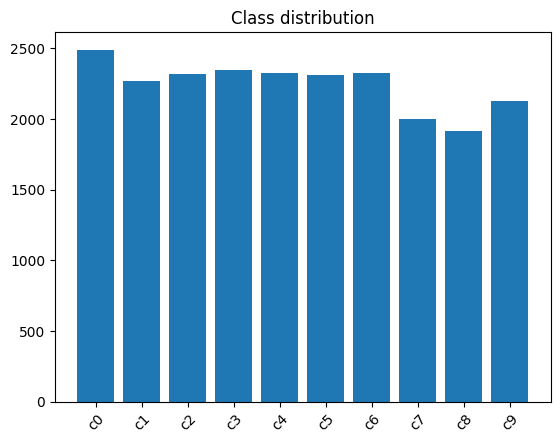

In [31]:
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Class distribution")
plt.show()

##### Here, we calculate basic dataset statistics. By sampling some images, we compute the average pixel values (mean) and how much they vary (standard deviation) across all classes. These stats help us understand the dataset better and can be useful for normalizing images during training.

In [32]:
def get_stats(file_list):
    means, stds = [], []
    for f in file_list[:200]:  # sample for speed
        img = np.array(Image.open(f).convert("RGB")) / 255.0
        means.append(img.mean(axis=(0,1)))
        stds.append(img.std(axis=(0,1)))
    return np.mean(means, axis=0), np.mean(stds, axis=0)

all_files = [os.path.join(DATA_DIR, c, f) for c in class_map for f in os.listdir(os.path.join(DATA_DIR, c))]
mean, std = get_stats(all_files)
print("Dataset mean:", mean)
print("Dataset std:", std)

Dataset mean: [0.30811307 0.3758733  0.36485968]
Dataset std: [0.28211798 0.32854327 0.32931074]


In [33]:
bad_files = []
for f in all_files:
    try:
        Image.open(f).verify()
    except:
        bad_files.append(f)
print("Corrupted files:", bad_files)

Corrupted files: []


###### We discovered that there's no corrupted files

##### This section loads the dataset from the training folder and splits it into training and validation sets using the class labels c0–c9. Images are resized, batched, and shuffled, and performance is improved with caching and prefetching. Finally, a few sample images are displayed with their class labels so we can visually confirm the data looks correct.

Found 22424 files belonging to 10 classes.
Using 19061 files for training.
Found 22424 files belonging to 10 classes.
Using 3363 files for validation.


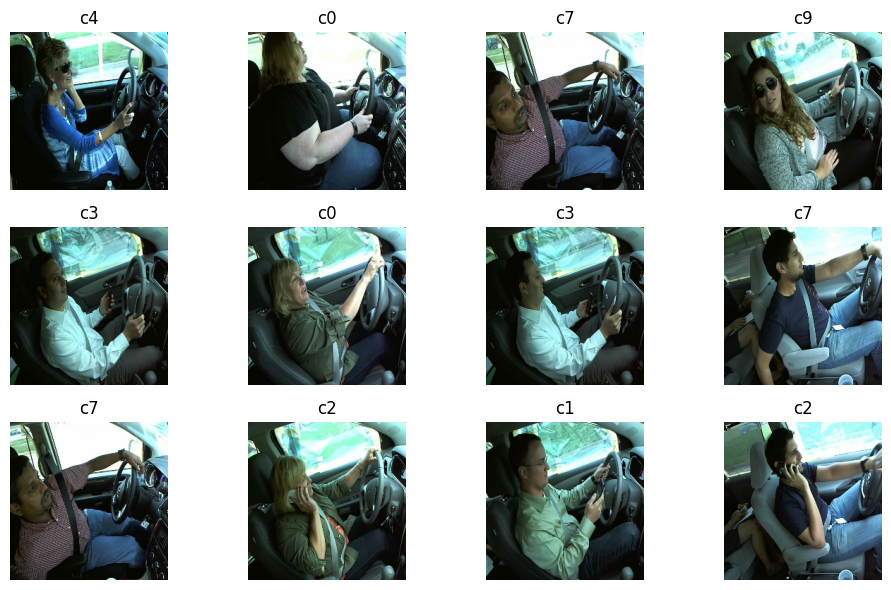

In [37]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    validation_split=VAL_SPLIT,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    validation_split=VAL_SPLIT,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Improve performance with caching & prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

# Peek at a few samples
for imgs, labels in train_ds.take(1):
    plt.figure(figsize=(10,6))
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i].numpy()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

##### This function counts how many images are in each class folder (c0–c9) and prints the results, giving a quick overview of dataset distribution.

In [38]:
def get_class_counts(data_dir, class_names):
    counts = {}
    for c in class_names:
        folder = os.path.join(data_dir, c)
        counts[c] = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    return counts

counts = get_class_counts(DATA_DIR, CLASS_NAMES)
print("Image counts per class:", counts)

Image counts per class: {'c0': 2489, 'c1': 2267, 'c2': 2317, 'c3': 2346, 'c4': 2326, 'c5': 2312, 'c6': 2325, 'c7': 2002, 'c8': 1911, 'c9': 2129}


##### This code calculates class weights so that underrepresented classes get more importance during training. It prints the weights for all classes (c0–c9).

In [39]:
total = sum(counts.values())
class_weight = {}
for idx, c in enumerate(CLASS_NAMES):
    # Inverse frequency: more weight to underrepresented classes
    class_weight[idx] = total / (len(CLASS_NAMES) * counts[c])
print("Class weights:", class_weight)

Class weights: {0: 0.9009240658899156, 1: 0.9891486546096162, 2: 0.9678031937850669, 3: 0.9558397271952259, 4: 0.9640584694754945, 5: 0.9698961937716263, 6: 0.9644731182795699, 7: 1.12007992007992, 8: 1.1734170591313449, 9: 1.0532644434006575}


##### **Data Argumentation**

##### This code sets up data augmentation (flipping, slight rotation, zoom) to make the model more robust, and defines a preprocessing step using MobileNetV2’s built-in function to prepare images for training.

In [40]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augmentation")

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

##### Here, we build our driver distraction classification model. We use MobileNetV2 as the base, starting with pretrained ImageNet weights. We freeze this base so it doesn’t retrain, and then let’s add our own custom layers on top: data augmentation, preprocessing, global average pooling, dropout (to help prevent overfitting), and finally a dense layer that predicts the 10 driver activity classes. We then compile the model with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the metric. Finally, let’s print out a summary to see the full architecture.

In [41]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(CLASS_NAMES), activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

##### Here, we set up callbacks to make training smarter. We use a ModelCheckpoint to save the best version of our model based on validation accuracy. We also add EarlyStopping, so if the model stops improving for a few rounds, training ends early and we restore the best weights. Finally, we use ReduceLROnPlateau to automatically lower the learning rate if validation loss stops improving.

In [42]:
checkpoint_path = os.path.join(OUTPUT_DIR, "best_model.keras")
callbacks = [
    keras.callbacks.ModelCheckpoint(
        checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1, min_lr=1e-6
    )
]

##### Now we train our model!. We fit it on the training set, validate on the validation set, run it for the number of epochs we set earlier, and apply the class weights and callbacks to keep training balanced and efficient. The training progress gets stored in history so we can review it later.

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

##### Let’s visualize how our model trained. We define a function to plot both accuracy and loss curves for training and validation. This helps us quickly see if the model is learning well, overfitting, or underfitting. Finally, we call the function with our training history to display the graphs.

In [ ]:
def plot_curves(h):
    plt.figure(figsize=(10,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curves(history)

##### Now that training is done, let’s save our model as distracted_driver_detector.keras so we can reuse it later. We also print out the class_map so we have a clear reminder of what each class label means.

In [ ]:
model.save("distracted_driver_detector.keras")
print("Classes:", class_map)

### **Testing with the best model**

##### Now let’s load our saved model and use it for predictions. We define a helper function predict_image that takes an image, resizes it to 224×224, and prepares it for the model. The model then outputs probabilities for all classes, and we grab the top-k predictions (by default, the top 2). Finally, we print out the predicted driver behaviors with their confidence scores.

In [ ]:
model = keras.models.load_model("distracted_driver_detector.keras")

class_names = [
    'Safe Driving',
    'Texting - Right',
    'Talking on the Phone - Right',
    'Texting - Left',
    'Talking on the Phone - Left',
    'Operating the Radio',
    'Drinking',
    'Reaching Behind',
    'Hair and Makeup',
    'Talking to Passenger'
]

def predict_image(path, top_k=2):
    img = Image.open(path).convert("RGB").resize((224,224))
    x = np.array(img, dtype=np.float32)
    x = tf.convert_to_tensor(x)[None, ...]

    # forward pass
    logits = model(x, training=False)
    probs = tf.nn.softmax(logits, axis=-1).numpy()[0]

    # top-k indices sorted by probability
    top_idxs = np.argsort(-probs)[:top_k]
    results = [(class_names[i], float(probs[i])) for i in top_idxs]
    return results

# Get top-2 suggestions
preds = predict_image("img_1000.jpg", top_k=2)
for label, conf in preds:
    print(label, round(conf, 3))